In [1]:
import torch
import os
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision.transforms as T
import numpy as np
from PIL import Image
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style("darkgrid")

In [2]:
if len(os.listdir('data/')) == 0:
    ZipFile("images_background.zip").extractall("data/")
    ZipFile("images_evaluation.zip").extractall("data/")



In [3]:
class OmniglotTrain(Dataset):

    def __init__(self, dataPath, transform=None):
        super(OmniglotTrain, self).__init__()
        np.random.seed(0)
        # self.dataset = dataset
        self.transform = transform
        self.datas, self.num_classes = self.loadToMem(dataPath)

    def loadToMem(self, dataPath):
        print("begin loading training dataset to memory")
        datas = {}
        agrees = [0, 90, 180, 270]
        idx = 0
        for agree in agrees:
            for alphaPath in os.listdir(dataPath):
                for charPath in os.listdir(os.path.join(dataPath, alphaPath)):
                    datas[idx] = []
                    for samplePath in os.listdir(os.path.join(dataPath, alphaPath, charPath)):
                        filePath = os.path.join(dataPath, alphaPath, charPath, samplePath)
                        datas[idx].append(Image.open(filePath).rotate(agree).convert('L'))
                    idx += 1
        print("finish loading training dataset to memory")
        return datas, idx

    def __len__(self):
        return  19800

    def __getitem__(self, index):
        # image1 = random.choice(self.dataset.imgs)
        label = None
        img1 = None
        img2 = None
        # get image from same class
        if index % 2 == 1:
            label = 1.0
            idx1 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx1])
        # get image from different class
        else:
            label = 0.0
            idx1 = random.randint(0, self.num_classes - 1)
            idx2 = random.randint(0, self.num_classes - 1)
            while idx1 == idx2:
                idx2 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx2])

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32))


class OmniglotTest(Dataset):

    def __init__(self, dataPath, transform=None, times=200, way=20):
        np.random.seed(1)
        super(OmniglotTest, self).__init__()
        self.transform = transform
        self.times = times
        self.way = way
        self.img1 = None
        self.c1 = None
        self.datas, self.num_classes = self.loadToMem(dataPath)

    def loadToMem(self, dataPath):
        print("begin loading test dataset to memory")
        datas = {}
        idx = 0
        for alphaPath in os.listdir(dataPath):
            for charPath in os.listdir(os.path.join(dataPath, alphaPath)):
                datas[idx] = []
                for samplePath in os.listdir(os.path.join(dataPath, alphaPath, charPath)):
                    filePath = os.path.join(dataPath, alphaPath, charPath, samplePath)
                    datas[idx].append(Image.open(filePath).convert('L'))
                idx += 1
        print("finish loading test dataset to memory")
        return datas, idx

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        # generate image pair from same class
        if idx == 0:
            self.c1 = random.randint(0, self.num_classes - 1)
            self.img1 = random.choice(self.datas[self.c1])
            img2 = random.choice(self.datas[self.c1])
        # generate image pair from different class
        else:
            c2 = random.randint(0, self.num_classes - 1)
            while self.c1 == c2:
                c2 = random.randint(0, self.num_classes - 1)
            img2 = random.choice(self.datas[c2])

        if self.transform:
            img1 = self.transform(self.img1)
            img2 = self.transform(img2)
        return img1, img2

In [4]:
transforms = T.Compose([
        T.RandomAffine(15),
        T.ToTensor()
    ])

train_dataset = OmniglotTrain('data/images_background',transform = transforms)
train_dataloader = DataLoader(train_dataset,32)

begin loading training dataset to memory
finish loading training dataset to memory


In [5]:
a,b,c = next(iter(train_dataloader)) # img1 , img2 , label
print(len(a),b[0].shape,c.shape,sep = '\n')
print(c[:5])

32
torch.Size([1, 105, 105])
torch.Size([32, 1])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.]])


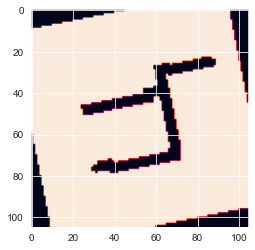

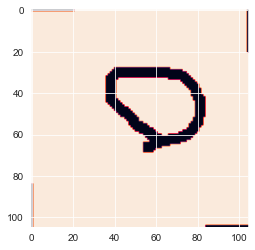

In [6]:
plt.imshow(a[0][0].numpy())
plt.show()

plt.imshow(b[0][0].numpy())
plt.show()

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class siamese_model(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        return torch.sigmoid(out)
    
device = 'cuda'

model = siamese_model()
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.00006)

epoch = 75
loss_history = [[],[]]
accuracy_history = [[],[]]
train_n_minibatches = train_dataloader.__len__()

In [8]:
train_n_minibatches

619

In [9]:
for e in range(epoch):
    for batch_idx , (x , y , z) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y , z = x.to(device) , y.to(device) , z.to(device)
        y_pred = model(x,y)
        
        # Calculating Loss
        loss = criterion(y_pred,z)
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = z.cpu().detach().numpy().tolist()
        for i,j in zip(y,y_pred):
            if round(j[0]) == int(i[0]):
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)

    # Saving the model progress
    torch.save(model.state_dict(),'saved_model/siamese_modelv1')
    
    #Log for e+1th epoch
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    loss_history[1].append(sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches)
    accuracy_history[1].append(sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches)
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {loss_history[1][-1]}',end = ' ')
    print(f'TRAIN ACCURACY : {accuracy_history[1][-1]}')
    print(f'---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 0.5325350706527229 TRAIN ACCURACY : 72.51110662358643
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 2-------------------------------------------
Loss for EPOCH 2  TRAIN LOSS : 0.43285077569557895 TRAIN ACCURACY : 81.17763866451266
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 3-------------------------------------------
Loss for EPOCH 3  TRAIN LOSS : 0.39113214234061694 TRAIN ACCURACY : 83.59753634894992
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 4-------------------------------------------
Loss for EPOCH 4  TRAIN LOSS : 0.3375839792035508 TRAIN ACCURACY : 86.38597199784599
----------------

---------------------------------------EPOCH 32-------------------------------------------
Loss for EPOCH 32  TRAIN LOSS : 0.10978440052388846 TRAIN ACCURACY : 96.39876144318794
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 33-------------------------------------------
Loss for EPOCH 33  TRAIN LOSS : 0.11153655964429814 TRAIN ACCURACY : 96.16821486268175
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 34-------------------------------------------
Loss for EPOCH 34  TRAIN LOSS : 0.11338547843482845 TRAIN ACCURACY : 96.18840872374798
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 35-------------------------------------------
Loss for EPOCH 35  TRAIN LOSS : 0.11005049112203241 TRAIN ACCURACY : 96.29947495961228
------

---------------------------------------EPOCH 63-------------------------------------------
Loss for EPOCH 63  TRAIN LOSS : 0.06808028085404023 TRAIN ACCURACY : 97.67770597738287
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 64-------------------------------------------
Loss for EPOCH 64  TRAIN LOSS : 0.07109253379547899 TRAIN ACCURACY : 97.65078082929456
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 65-------------------------------------------
Loss for EPOCH 65  TRAIN LOSS : 0.06565702458323011 TRAIN ACCURACY : 97.82411147011308
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 66-------------------------------------------
Loss for EPOCH 66  TRAIN LOSS : 0.06555807978999598 TRAIN ACCURACY : 97.82411147011308
------

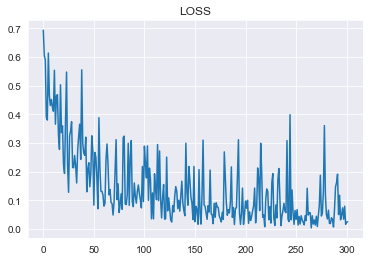

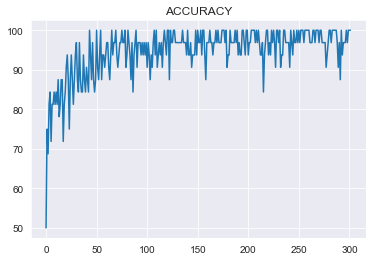

In [10]:
plt.plot(loss_history[0][::int(len(loss_history[0])/300)])
plt.title('LOSS')
plt.show()

plt.plot(accuracy_history[0][::int(len(accuracy_history[0])/300)])
plt.title('ACCURACY')
plt.show()

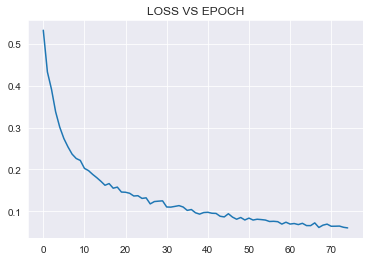

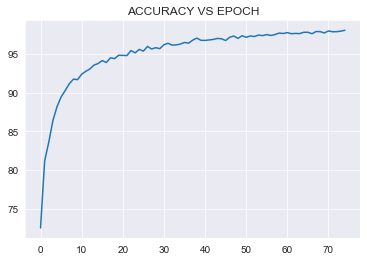

In [11]:
plt.plot(loss_history[1])
plt.title('LOSS VS EPOCH')
plt.show()

plt.plot(accuracy_history[1])
plt.title('ACCURACY VS EPOCH')
plt.show()